In [62]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import json
import os
from time import time
import statistics as st

# Question 1

Simulate a time series with $n = 500$ realisations distributed according to a probability law $L$ of your choice. This time series must have $K^∗ ≥ 2$ changes in one or more dimensions of the parameters of $L$ (you set the value of $K^∗$ as you wish). Plot this time series.

## Answer 1

We choose an Exponential distribution for the time series simulation, the code below shows the function `expovariate`, which create functions that generates random values of exponential distibution with parameter $ \lambda = l$. 

In [63]:
def expovariate(l):
    return lambda : random.expovariate(l)

In [64]:
#Lets initialize 3 functions exp_1, exp_4 and exp_5, using expovariate in order to get funcions that generate 
#random values of exponential distribution with lambdas = 1,4,5 respectively

exp_1 = expovariate(1)
exp_4 = expovariate(4)
exp_5 = expovariate(5)

In [65]:
#Given the times series inteval, the change points and the distibution function to generate the values 
# in each segment of the time series, this function returns the time series simulated

def generate_time_series(interval,
                         change_points,
                         distributions):
    time_series = []
    points =  [interval[0]] + change_points + [interval[1]]
    for p in range(len(distributions)):
        point_left = points[p]
        point_right = points[p + 1]
        for _ in range(point_left, point_right, 1):
            time_series.append(distributions[p]())
    return time_series


In [90]:
#This function plots the times series, if change points are also given then includes gray dashed lines in 
#their place and if the aproximation values for change points are given too, plots red dashed lines on those
#values too

def plot_time_series(time_series, change_points= None, approx_change_points= None):
    plt.plot(range(len(time_series)), time_series, '.', color= 'black')
    min_point = min(time_series)
    max_point = max(time_series)
    if change_points is not None:
        first = True
        for change_point in change_points:
            if first:
                plt.vlines(change_point, min_point, max_point, colors= 'gray', linestyles='dashed', label='reals CP')
                first = False
            else:
                plt.vlines(change_point, min_point, max_point, colors= 'gray', linestyles='dashed')
    if approx_change_points is not None:
        first = True
        for change_point in approx_change_points:
            if first:
                plt.vlines(change_point, min_point, max_point, colors= 'red', linestyles='dashed', label='approxs CP')
                first = False
            else:
                plt.vlines(change_point, min_point, max_point, colors= 'red', linestyles='dashed')
    plt.legend()
    plt.show()

Now let's generate a time serie on time interval $[0; 500]$, and let's add 3 change points on $200$, $250$ and $350$, for that we generate random exponentialy distributed values, using the previously defined functions exp_1, exp2 adn exp_3, getting $4$ intervals $[0; 200)$, $[200,250)$, $[250;350)$ and $[350,500]$ with values coresponding to exponential distributions with $\lambda = 1,5,1,4$ respectively using `generate_time_series` function. Finally we plot the resulting time series and the real change points moments with `plot_time_series` function.

In [67]:
# ALERTA!!!!
# Si desea generar un nuevo conjunto de datos descomente el siguiente codigo
# Esto generaria una nueva serie del tiempo, y todas las imagenes de los resultados actuales cambiarian
# Le recomendamos utilizar el conjunto de ejemplo generado con el que se redacto el informe

#################################
# Generar nueva serie de tiempo #
#################################

# interval = (0, 500)
# change_points = [200, 250, 350]
# distributions = [exp_1, exp_5, exp_1, exp_4]
# time_series = generate_time_series(interval, change_points, distributions)
# with open('example.json', 'w') as fp:
#     json.dump(time_series, fp)

#########################################
# Utilizar la serie de tiempo propuesta #
#########################################

change_points = [200, 250, 350]
with open('example.json', 'r') as fp:
    time_series = json.load(fp)

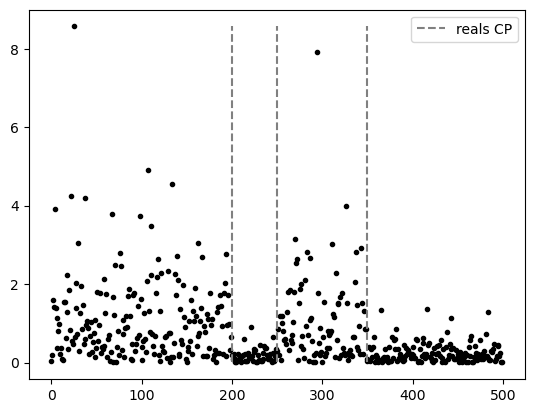

In [68]:
plot_time_series(time_series, change_points)

# Question 2

Derive a cost function that is appropriate for the data simulated in Question 1. Briefly justify your choice (in a comment in your code).

## Answer 2


Assuming that is known that the time series has exponential distribution, but the $\lambda$ of the distribution of each interval, is not. We are going to use the negative logarithm of likelihood function. Let's start finding those $\lambda$ values, for which the value of this function is minimal, keeping constant $y_i$ (value of time series at instant $i$) values for all  $0 < i \le n$. Note that find the minimum value, is equivalent to find the maximum in the possitive function, and that can be done finding the **maximum likelihood estimator**. Given $y_i$, we must maximice:

<!-- Supongamos que sabemos que los puntos simulados tienen distribución exponencial pero no sabemos con qué parámetro $\lambda$, para cada uno de los intervalos entre `CP` y `CP`. Para ello utilizaremos como función de costo el logaritmo negativo de la función de verosímilitud. Pero antes debemos hallar para qué valor de $\lambda$ este valor es mínimo manteniendo constante los valores de $y_i$ para todo $0 < i \le n$. Note que hallar el valor mínimo es equivalente a hallar el valor máximo de la misma función positiva, lo cual sería el método del máximo verosímil. Dada cada $y_i$, debemos maximizar: -->

$$ L(\lambda | y_1...y_n) = Π_{i=1}^n \lambda e^{-\lambda y_i}  = \lambda^n e^{-\lambda \sum_{i = 1}^{n} y_i} $$

Which is equivalent to maximice:
<!-- Sin embargo esto es equivalente a maximizar: -->

$$ \ln(\lambda^n e^{-\lambda \sum_{i = 1}^{n} y_i}) = \ln(\lambda^n) + \ln(e^{-\lambda \sum_{i = 1}^{n} y_i}) = n\ln(\lambda) -\lambda \sum_{i = 1}^{n} y_i $$

At last we derive and make the function equal $0$, in order to find such value:
<!-- Por último derivamos e igualamos a $0$ para encontrar este valor: -->

$$ 0 = \frac{dL(n\ln(\lambda) -\lambda \sum_{i = 1}^{n} y_i)}{d\lambda} = \frac{n}{\lambda} - \sum_{i = 1}^{n} y_i$$

Finally we get the estimated expression value of $\lambda$:
<!-- Y finalmente obtenemos que el valor estimado de $\lambda$ es: -->

$$ \lambda_{MLE} = \frac{n}{\sum_{i = 1}^{n} y_i}$$

With the estimated $\lambda$, we go back on our possitive cost function and replace $\lambda$ expression on it:
<!-- Ahora bien, estimado $\lambda$ regresamos a nuestra función de costo versión positiva y sustituimos obteniendo: -->

$$ n\log(\lambda_{MLE}) -\lambda_{MLE} \sum_{i = 1}^{n} y_i = n\log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) - \frac{n}{\sum_{i = 1}^{n} y_i} \sum_{i = 1}^{n} y_i$$ 
$$ = n\log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) - n = n \left(\log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) - 1\right) $$

But, the purpose of this in the end is minimaze this value at the change points, so we need to work with the opposite, the negative of this function, the original cost function, so it is:
<!-- Pero como lo que queremos es minimizar más adelante con nuestros algoritmos de búsqueda de puntos de ruptura, lo que haremos es trabajar con el opuesto de este, lo que quedaría: -->

$$ n \left(1 - \log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) \right) $$

Let's rename this cost function for an easier aplication on intervals $[a;b]$ of time series:
<!-- Para formalizar más la función de costo, utilizaremos la notación: -->

$$ c(y_{a:b}) = n \left(1 - \log \left(\frac{n}{\sum_{i = a}^{b} y_i} \right) \right) $$

where $n = b-a+1$.

In [69]:
#Function that given the values on an interval if time series compute the cost function for the interval
def cost_funtion_exp(points):
    n = len(points)
    if n == 0:
        return 0     
    return n * (1 - math.log(n / sum(points)))

# Question 3

Implement the optimal partition algorithm and test it on the data simulated in question 1.

## Answer 3

The following code is an implementation of  `Optimal Partition` algorithm, it receives as data:

- The time series
- The cost function
- The amount on change points

In [70]:
def OptimalPartition(points, cost_func, K):

    n = len(points)
    Ms = np.zeros((K,n,n)) #Initialize the arrays
    for u in range(n):
        for v in range(n):
            if u < v:
                Ms[0][u][v] = cost_func(points[u:v+1]) #The initial values (base case) of dp

    if K > 1: #Fill the arrays using dp 
        for k in range(1, K):
            for u in range(n):
                for v in range(n):
                    if v-u > k+1:
                        Ms[k][u][v] = min([Ms[k-1][u][t] + Ms[0][t+1][v] for t in range(u+k-1, v)])
    L = np.zeros((K+1), dtype=int) #List of change points    
    L[K] = n-1  
    k = K
    while k > 0: #Find the change points using the pre-computed values on dp arrays 
        s = L[k]        
        ts = [Ms[k-1][0][t] + Ms[0][t+1][s] for t in range(k, s)]
        ts_min =  min(ts)
        t_index = ts.index(ts_min)
        L[k-1] = t_index
        k= k -1
    return L[:-1]
    

We then use the `OptimalPartition` algorithm to predict the change points on the previously simulated data, the results are shown below.

In [71]:
approx_change_points_OP = OptimalPartition(time_series, cost_funtion_exp, 3)
approx_change_points_OP

array([198, 248, 345])

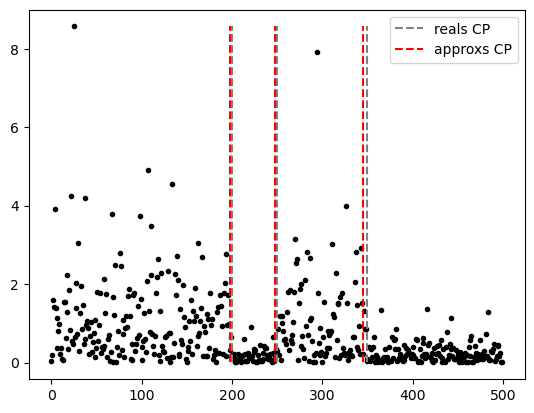

In [91]:
plot_time_series(time_series, change_points, approx_change_points_OP)

# Question 4

Implement the PELT algorithm and test it using the data simulated in question 1. You will set the value of the penalty weight as $log(n)$.

## Answer 4

For `PELT` algorithm implementation, we base our implementation on Conference's notes and the article **"Killick, R., Fearnhead, P., & Eckley, I. A. (2012, oct). Optimal detection of changepoints with a linear computational cost. Journal of the American Statistical Association"**. Is important to note that `PELT` uses the **Theorem 3.1** to rule out possible change points. This theorem expresses the following: 

<!-- A continuación se hace una implementación del algoritmo `PELT`. Nos basamos tanto en la implementación de Conferencia como la explicada en el artículo **"Killick, R., Fearnhead, P., & Eckley, I. A. (2012, oct). Optimal detection of changepoints with a linear computational cost. Journal of the American Statistical Association"**. Es importante señalar que PELT hace uso del **Teorema 3.1** de este artículo para descarta posibles puntos de cambios. Este Teorema expresa lo siguiente: -->

*Theorem 3.1*: We assume that when introducing a changepoint into a sequence of observations, the cost, $C$, of the sequence reduces. More formally, we assume there exists a constant $K$ such that for all $t < s <T$.

Then pseudo-code of our algorithm looks like:
<!-- Luego el pseudocódigo de nuestro algoritmo sería: -->

**Input**:
- `data` $= \{y_1,...,y_n\}$: set of points
- $c(.)$: cost function
- $\beta$: penalty cost
- `K`: constant that satisfies **Theorem 3.1**
- $n_{min}$: minimal interval size

**Initializations**:
- `F` = $(-\beta,..., n_{min}-1 = -\beta, 0,...,0)$: array of size `n`
- `R` = $\{0\}$: initial set of possible change points
- `CP` = $(0,...,0)$: array de puntos de cambios asociados a cada dato

**Pseudo-Code**:

- **for all** $t^* = n_{min},..., n-1$:  
    - $F[\widetilde{ t }] = \min_{t \in R  ~ \backslash ~ |\widetilde{ t }-t| \ge n_{min} }\{F(t) + c(y_{t:\widetilde{ t }})+ \beta\}$
    - $\overline{t} = \argmin_{t \in R  ~ \backslash ~ |\widetilde{ t }-t| \ge n_{min} }\{F(t) + c(y_{t:\widetilde{ t }-1})+ \beta\}$
    - $ CP[\widetilde{ t }] = \overline{t} $
    - $ R^* = \{ \widetilde{ t } \} \cup \{ t \in R ~ \backslash ~ F[t] + c(y_{t:\widetilde{ t }-1}) + K < F[\widetilde{ t }]\} $
    - $ R = R^*$
- **end for**
- `last = CP[n-1]`
- **while** `last != 0` :
    - **add** `last` **to** `changes_points`
    - `last = CP[last]`
- **end while**  

**Output**
- `change_points`: Change Points

In [73]:
def PELT(points, cost_func, penalty= None, n_min=0, K= 0):

    n = len(points)
    F = np.zeros(n, np.float32)

    if penalty is None:
        penalty = np.log(n)

    for i in range(n_min):
        F[i] = - penalty
    CP = np.zeros(n, np.int32)
    R = np.array([0], dtype=np.int32)

    for t_accent in range(n_min, n):
        
        np.array(F[t_accent])         
        interval_costs = np.zeros(R.shape[0], np.float32)
        interval_costs_pen = []
        for i, change_point_cand in enumerate(R):            
            interval_costs[i] = F[change_point_cand] + cost_func(points[change_point_cand: t_accent])
            if abs(R[i] - t_accent) >= n_min:
                interval_costs_pen.append((interval_costs[i] + penalty, R[i]))

        F[t_accent], CP[t_accent] = min(interval_costs_pen)
        
        R_new = []
        for i, val in enumerate(interval_costs):
            if val + K < F[t_accent]:
                R_new.append(R[i])
        R_new.append(t_accent)
        R = np.array(R_new, dtype=np.int32)

    finals_CP = []
    last = CP[-1]
    while last > 0:
        finals_CP.append(last)
        last = CP[last]
    finals_CP.reverse()
    return finals_CP

We then use the `PELT` algorithm to predict the changepoints on the previously simulated data, and we take as:

- $\beta = \log(n)$
- $K = 0$ because like the article says, that is the value which satisfiesl **Theorem 3.1**

The results are shown below. 

In [74]:
approx_change_points_PELT = PELT(time_series, cost_funtion_exp, n_min=10)
approx_change_points_PELT

[200, 251, 349]

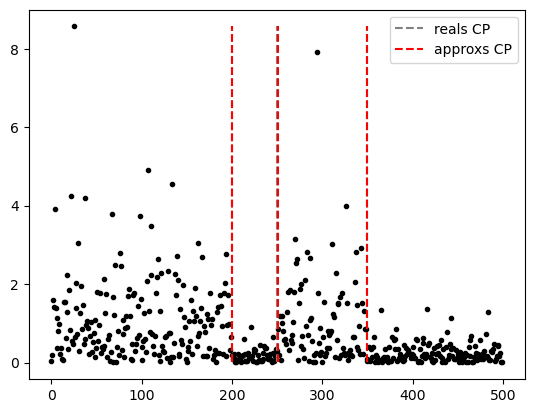

In [93]:
plot_time_series(time_series, change_points, approx_change_points_PELT)

# Question 5

Test the PELT algorithm with other values of the penalty weight. Comment the results.

## Answer 5

Turning to choice of penalty, in practice by far the most common choice is one which is linear in the number of changepoints. Examples of such penalties include Akaike’s Information Criterion (AIC) where $\beta = 2p$ and Schwarz Information Criterion (SIC also known as BIC) where $\beta = p\log n$; $p$ is the
number of additional parameters introduced by adding a changepoint and $n$ is the size of time series. [Killick, R., Fearnhead, P. and Eckley, I.A. "Optimal detection of changepoints with a linear
computational cost". October 10, 2012.]

For a model with 1 parameter fit per segment, each change point adds two parameters to the model (1 for the segment parameter and 1 for the new change point). It means that $p =2$. 

In [76]:
def BIC(p,n):
    return p * np.log(n)

def AIC(p):
    return 2*p

In [77]:
bic  = BIC(2,len(time_series))
aic  = AIC(2)

In [78]:
approx_change_points_PELT_aic = PELT(time_series, cost_funtion_exp, penalty= aic, n_min=10)
print("penalty AIC = ",  approx_change_points_PELT_aic)

approx_change_points_PELT_bic = PELT(time_series, cost_funtion_exp, penalty= bic, n_min=10)
print("penalty BIC = ",  approx_change_points_PELT_bic)

penalty AIC =  [200, 251, 349]
penalty BIC =  [200, 251, 349]


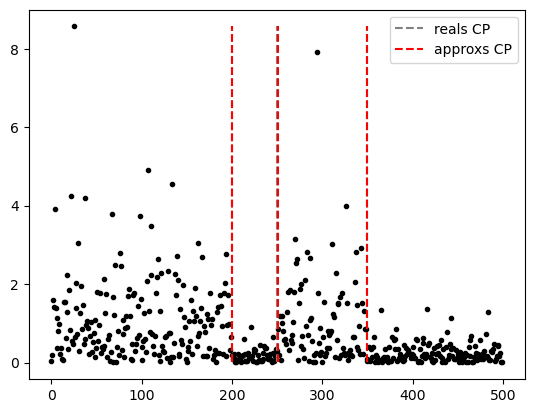

In [92]:
plot_time_series(time_series, change_points, approx_change_points_PELT_aic)

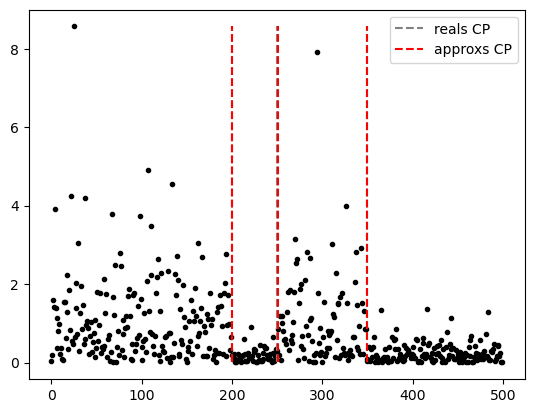

In [94]:
plot_time_series(time_series, change_points, approx_change_points_PELT_bic)

## Complementary Analisis
A remarcable difference between `Optimal Pertition` and `PELT` algorithm is the time complexity. The first one is more expensive, a closer look to this fact on other simulated data will provide an experimental proove for this statement; that is teorycally explained by $O(n)$ boundaries of each algorithm.
<!-- Una notable diferencia en ambos algoritmos es la complejidad temporal de ambos -->

In [81]:
# Generates `r` lists with `K` changepoints, in an interval [0, n),
# with a minimal distance equal to `min_dist`
def gen_many_change_points(n, K, min_dist, r):

    many_change_points = []    
    for _ in range(r):
        change_points = [0, n]
        while len(change_points) < K + 2:
            cp = random.randint(0,n-1)
            cp_valid = True
            for point in change_points:
                if abs(cp - point) <= min_dist:
                    cp_valid = False
                    break
            if cp_valid:
                change_points.append(cp)
        change_points = change_points[2:]
        change_points.sort()
        many_change_points.append(change_points)
    return many_change_points

We create 10 lists of 3 changepoints for each time series length between 100 and 3000 skipping 20, for a total of 1450 lists of change points. The commented code bellow generates the lists calling `gen_many_change_points` and saves them in a **many_change_points_to_simulate.json** file. Now we just need to open the file and load data and avoid to compute again all test cases, for that is the uncommnted line below. 


In [82]:

# many_change_points = {}
# for i in range(100, 3001, 20):
#     many_change_points[i] = gen_many_change_points(i,3,15,10)
# 
# with open('many_change_points_to_simulate.json', 'w') as fp:
#     json.dump(many_change_points, fp)

with open('many_change_points_to_simulate.json', 'r') as fp:
    many_change_points = json.load(fp)

In [83]:
func_OP = lambda time_series: OptimalPartition(time_series, cost_funtion_exp, 3)
func_PELT = lambda time_series: PELT(time_series, cost_funtion_exp, n_min=10)

Keeping $K=3$ changepoints, we simulate time series with length $n = 100, 120, 140, ... , 500$ with change points values taken from the lists created before and run $30$ times each algorithm. Then we compare the mean time result for each $n$ and plot it on the graph at the end of the document.  

<!-- Manteniendo $K=3$ puntos de cambios, simularemos $30$ corridas de cada algoritmo sobre un series de tiempo en un intervalo $n = 100, 120, 140, ..., 500$. Luego de esto, graficaremos la media del tiempo demorado para cada $n$. -->

In [84]:
def run_simulations(interval, many_change_points, distributions):

    results_change_points_OP = []
    results_times_OP = []

    results_change_points_PELT = []
    results_times_PELT = []

    for change_points in many_change_points:
        time_serie = generate_time_series(interval, change_points, distributions)

        time_OP_start = time()
        change_points_OP = list(map(int, OptimalPartition(time_serie, cost_funtion_exp, 3)))
        time_OP_end = time()

        results_change_points_OP.append(change_points_OP)
        results_times_OP.append(time_OP_end - time_OP_start)

        time_PELT_start = time()
        change_points_PELT = list(map(int, PELT(time_serie, cost_funtion_exp, n_min=10)))
        time_PELT_end = time()

        results_change_points_PELT.append(change_points_PELT)
        results_times_PELT.append(time_PELT_end - time_PELT_start)

    return results_change_points_OP, results_times_OP, results_change_points_PELT, results_times_PELT

In [85]:
# We create .json for save results
# Uncomment and run if you want to erase everythyng and start from zero

# empty = {}
# 
# with open('results_cps_OP.json', 'w') as fp:
#     json.dump(empty, fp)
# with open('results_times_OP.json', 'w') as fp:
#     json.dump(empty, fp)
# with open('results_cps_PELT.json', 'w') as fp:
#     json.dump(empty, fp)
# with open('results_times_PELT.json', 'w') as fp:
#     json.dump(empty, fp)

In [86]:
def get_results(many_change_points, n_from=100):

    for n, list_change_points in many_change_points.items():
        if int(n) < n_from:
            continue
        cps_OP, times_OP, cps_PELT, times_PELT = run_simulations((0,int(n)), list_change_points, [exp_1, exp_5, exp_1, exp_4])
        #############################################
        with open('results_cps_OP.json', 'r') as fp:
            old_cps_OP = json.load(fp)
            old_cps_OP[n] = cps_OP
        with open('results_cps_OP.json', 'w') as fp:
            json.dump(old_cps_OP, fp)
        #############################################
        with open('results_times_OP.json', 'r') as fp:
            old_times_OP = json.load(fp)
            old_times_OP[n] = times_OP
        with open('results_times_OP.json', 'w') as fp:
            json.dump(old_times_OP, fp)
        #############################################
        with open('results_cps_PELT.json', 'r') as fp:
            old_cps_PELT = json.load(fp)
            old_cps_PELT[n] = cps_PELT
        with open('results_cps_PELT.json', 'w') as fp:
            json.dump(old_cps_PELT, fp)
        #############################################
        with open('results_times_PELT.json', 'r') as fp:
            old_times_PELT = json.load(fp)
            old_times_PELT[n] = times_PELT
        with open('results_times_PELT.json', 'w') as fp:
            json.dump(old_times_PELT, fp)

In [87]:
## To execute again the results run the code below
## Execute again the simulations and the algorithm is going to take a while
## We recommend use the already computed ones


# get_results(many_change_points)

In [88]:
with open('results_times_OP.json', 'r') as fp:
    times_OP = json.load(fp)

with open('results_times_PELT.json', 'r') as fp:
    times_PELT = json.load(fp)

X = []
Y1 = []
for n, times in times_OP.items():
    X.append(int(n))
    Y1.append(st.mean(times))

Y2 = []
for n, times in times_PELT.items():
    Y2.append(st.mean(times))

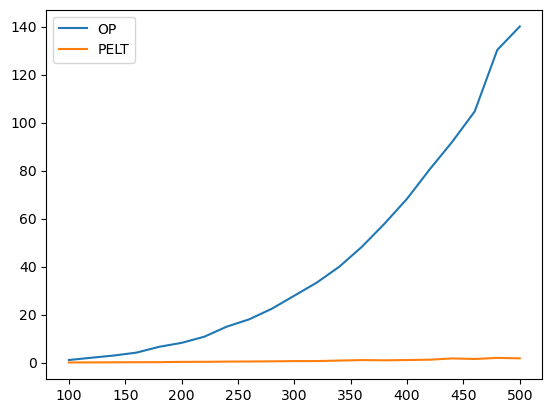

In [89]:
plt.plot(X, Y1, label = 'OP')
plt.plot(X, Y2, label = 'PELT')
plt.legend()
plt.show()

The graph shows the comparative results of both algoritms, measuring time of compute the changepoints on time series. The blue one belongs to `Optimal Partition` and it's running time increese considerably more than `PELT` when time series interval is larger.